In [1]:
%matplotlib inline
from glob import glob
from os.path import join as pjoin
from pprint import pprint
from scipy.ndimage import rotate
from tifffile import imread, imwrite, TiffFile
from tqdm import tqdm
from wf_utils import filename2int, log_progress
from wfield.io import load_stack, mmap_dat, frames_average_for_trials
# from wfield import hemodynamic_correction

import cv2, os, shutil, subprocess, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Preprocess

In [6]:
plot_test = True
# Set the file path
root_path = '/home/wrx/Data_WF/WF_WRX/'
mice_id = 'Q38'
treat = '20240826_saline'
# treat = ''
path_0 = pjoin(root_path, mice_id, treat)
print(path_0)

path_1_ = os.listdir(path_0)
# 筛选出文件夹
path_1 = [folder for folder in path_1_ if os.path.isdir(pjoin(path_0, folder))]
path_all = []
for path in path_1:
    path_all.append(pjoin(path_0, path))

pprint('All the file path:\n'+str(path_all))

/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline
('All the file path:\n'
 "['/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous', "
 "'/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy', "
 "'/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/3_Movingbar', "
 "'/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/4_SalienceGrating', "
 "'/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/5_SalienceMovingGrating', "
 "'/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/6_Looming', "
 "'/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/7_NatureMovie']")


In [5]:
path_0

'/home/wrx/Data_WF/WF_WRX/test/'

In [8]:
csv_path = '/home/wrx/Data_WF/WF_WRX/test/20240827-154837.csv'
df = pd.read_csv(csv_path, header=None).values
print(df.shape)

(34836, 4)


In [23]:
split_index = np.arange(0, df.shape[0], 1000)
split_index = np.append(split_index, df.shape[0])
print(split_index)

[    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000
 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 34836]


In [ ]:
velocity = np.zeros((df.shape[0], 1))

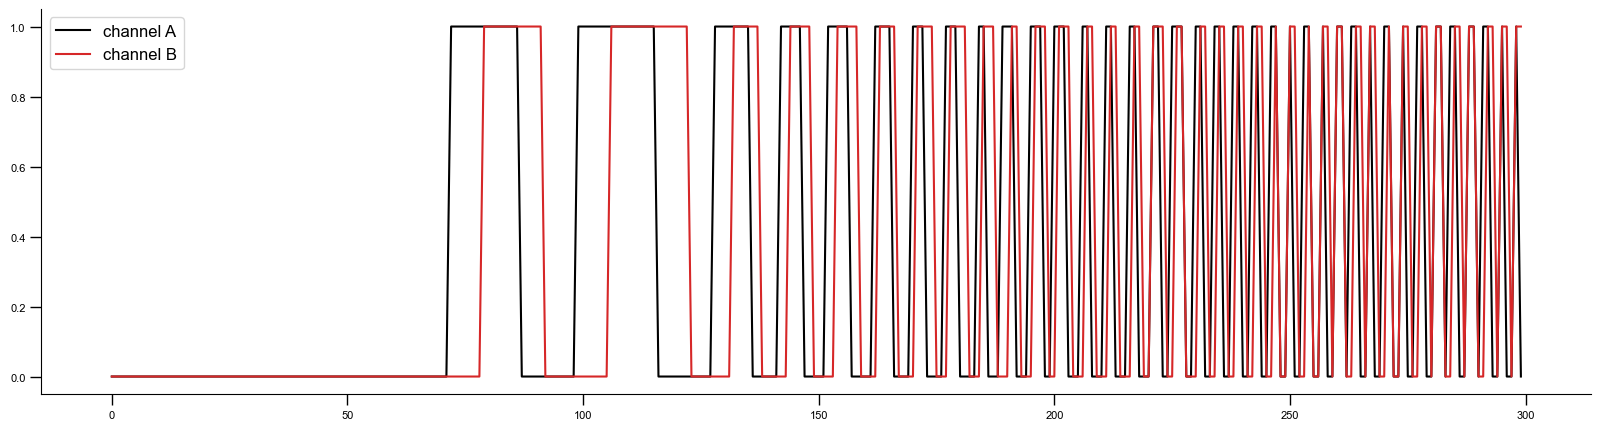

In [16]:
start = 4700
end = 5000
fig, ax = plt.subplots(figsize=(20, 5))
wave_A = df[start:end, 1]
wave_B = df[start:end, 2]
plt.plot(wave_A, label='channel A')
plt.plot(wave_B, label='channel B')
plt.legend()
plt.show()

In [19]:
# calculate the speed of a motor encoder based on wave_A and wave_B channels
# When the codewheel rotates in the clockwise direction (as viewed from the 
# encoder end of the motor), channel A will lead channel B. If the codewheel 
# rotates in the counterclockwise direction, channel B will lead channel A.

raise_A = np.where(np.diff(wave_A) == 1)[0]
print(raise_A)
count = 0
for i in range(len(raise_A)):
    if wave_B[raise_A[i]] == 0:
        count +=1
    else:
        count -=1
print(count)


[ 71  98 127 141 151 161 169 176 183 188 194 199 205 210 215 220 224 229
 233 237 241 245 249 252 256 259 262 266 269 273 276 280 283 287 290 294
 297]
37


In [20]:
sample_rate = 1000 # Hz
velocity_rate = 10 # Hz
interval = sample_rate / velocity_rate

cpr = 200 # Counts per revolution
diammeter = 2.54 # diameter of the wheel, in cm

velocity = count / cpr * np.pi * diammeter
print(velocity, 'cm/s')

1.476234387921844 cm/s


In [7]:
# ### re-organize files

for path in path_all:
    if not os.path.exists(pjoin(path, 'raw')):
        os.mkdir(pjoin(path, 'raw'))
    if not os.path.exists(pjoin(path, 'process/')):
        os.mkdir(pjoin(path, 'process/'))
        
for path in path_all:
    files = glob(pjoin(path, '202?????-??????*'))
    for file in files:
        shutil.move(file, pjoin(path, 'raw', os.path.basename(file)))
        print('moving',file)

print('Moving raw data folders all finished!')


moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous/20240826-140905-405Timestamp.csv
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous/20240826-140905-470Timestamp.csv
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous/20240826-140905.csv
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous/20240826-140905-405
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous/20240826-140905-470
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous/20240826-140905-event
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy/20240826-142921-405Timestamp.csv
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy/20240826-142921-470Timestamp.csv
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy/20240826-142921.csv
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy/20240826-142921-405
moving /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy/20240826-142921-470
movin

In [8]:

def organize_tif(folder_path):
    folder_name = os.path.basename(folder_path)
    if os.path.exists(folder_path+'.tif'):
        print('importing {}.tif'.format(folder_path))
        image_stack = imread(folder_path+'.tif')
        print('finish importing {}.tif'.format(folder_path))
    else:
        image_path_ls = glob(pjoin(folder_path, '*.tif'))
        image_path_ls = sorted(image_path_ls, key=filename2int) # 确保图像帧按顺序排列
        image_stack = [imread(tiff) for tiff in log_progress(image_path_ls, name=folder_name)]  # 将多帧tif堆叠成数组
        # image_stack = multi_load_images(image_path_ls, n_thread=20)
    # rotated_images = [cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) for frame in image_stack]   # 顺时针旋转图像90度
    # 计算并保存均值数据
    mean_values = np.array(image_stack).mean(axis=(1,2))
    output_value = pjoin(processPath, folder_name + "-Values.csv")
    np.savetxt(output_value, mean_values, delimiter=",")
    
    return np.array(image_stack)

def rotate_crop_array(array, angle, left, top, width, height):
    '''
    Rotate the image by the angle and crop the image with the given coordinates
    Args:
        array: numpy array, the image to be rotated and cropped, 2D or 3D. 
        if 3D, the first dimension is the number of images
        angle: float, the rotation angle in degrees. Positive, counterclockwise; Negative, clockwise.
        left: int, the x coordinate of the top-left corner of the cropped image
        top: int, the y coordinate of the top-left corner of the cropped image
        width: int, the width of the cropped image
        height: int, the height of the cropped image
    '''
    if not angle == 0:
        if array.ndim == 2:
            rotated = rotate(array, angle, reshape=False)
        if array.ndim == 3:
            print('Rotating the images...')
            print('This may take a while..., please wait')
            rotated = rotate(array, angle, axes=(2, 1), reshape=False)
        print(rotated.shape)
    else:
        rotated = array

    if left+width > rotated.shape[-2] or top+height > rotated.shape[-1]:
        print(left+width, rotated.shape[-2], top+height, rotated.shape[-1])
        print("The crop area is out of the image")
        return None
    else:
        if rotated.ndim == 3:
            print('Cropping the images...')
            cropped = rotated[:, top:top+height, left:left+width]
        if rotated.ndim == 2:
            cropped = rotated[top:top+height, left:left+width]
        return cropped

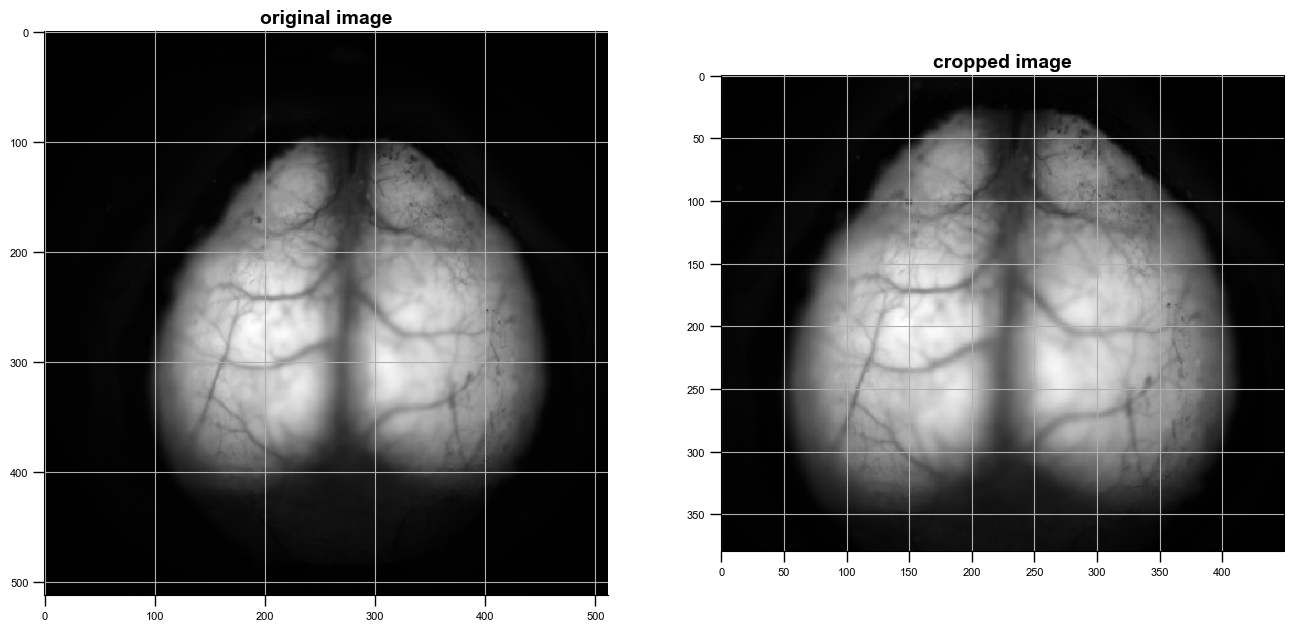

In [13]:
# use this to check wheather the images need rotation and the suitable angle,
# and the coordinates of ROI to crop the raw images

# select the first tif image of 470nm channel of the first experiment as the reference image
image_ref = imread(glob(pjoin(path_all[0], 'raw/*-470/1.tif'))[0])

# rotate iamge by pre-defined angle using scipy.ndimage.rotate
# rotate the images is time-consuming, so we skip rotate the images by setting angle=0
angle = 0 # if clockwise, use negative angle, otherwise positive
left, top, width, height = 45, 70, 450, 380
cropped_image = rotate_crop_array(image_ref, angle=angle, left=left, top=top, width=width, height=height)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(image_ref, cmap='gray', aspect='equal')
axs[0].set_title('original image')
axs[0].grid()
axs[1].imshow(cropped_image, cmap='gray', aspect='equal')
axs[1].set_title('cropped image')
axs[1].grid()
plt.show()

Path: /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous
experiments:
['20240826-140905']


Cropping the images...


Cropping the images...
saving merged tif of 20240826-140905


/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20240826-140905-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


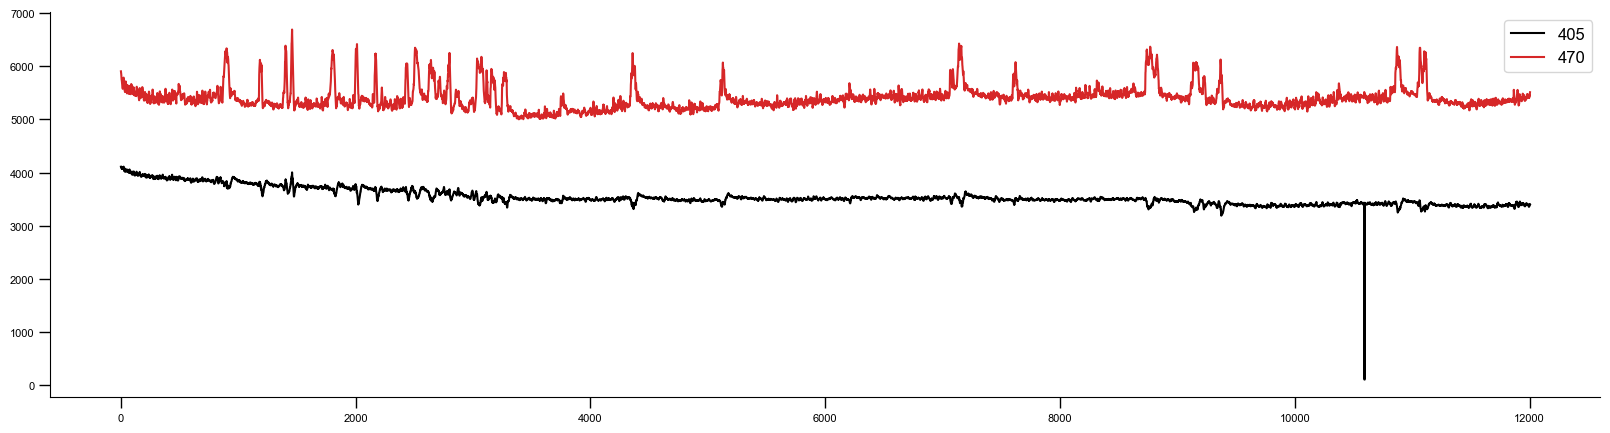

Path: /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy
experiments:
['20240826-142921']


Cropping the images...


Cropping the images...
saving merged tif of 20240826-142921


/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20240826-142921-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


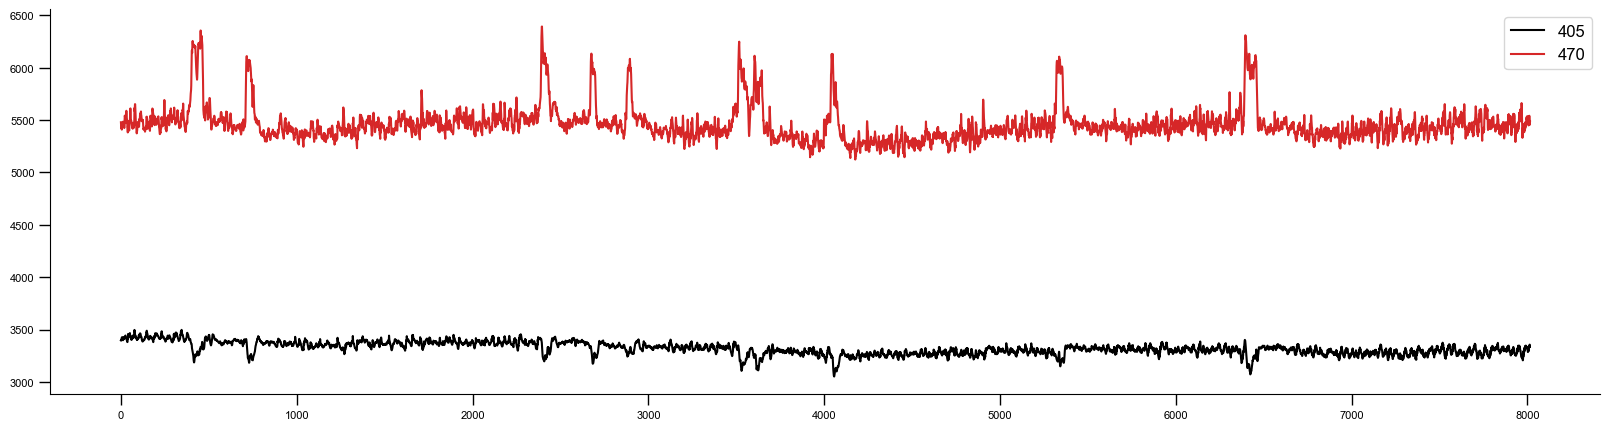

Path: /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/3_Movingbar
experiments:
['20240826-144645']


Cropping the images...


Cropping the images...
saving merged tif of 20240826-144645


/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20240826-144645-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


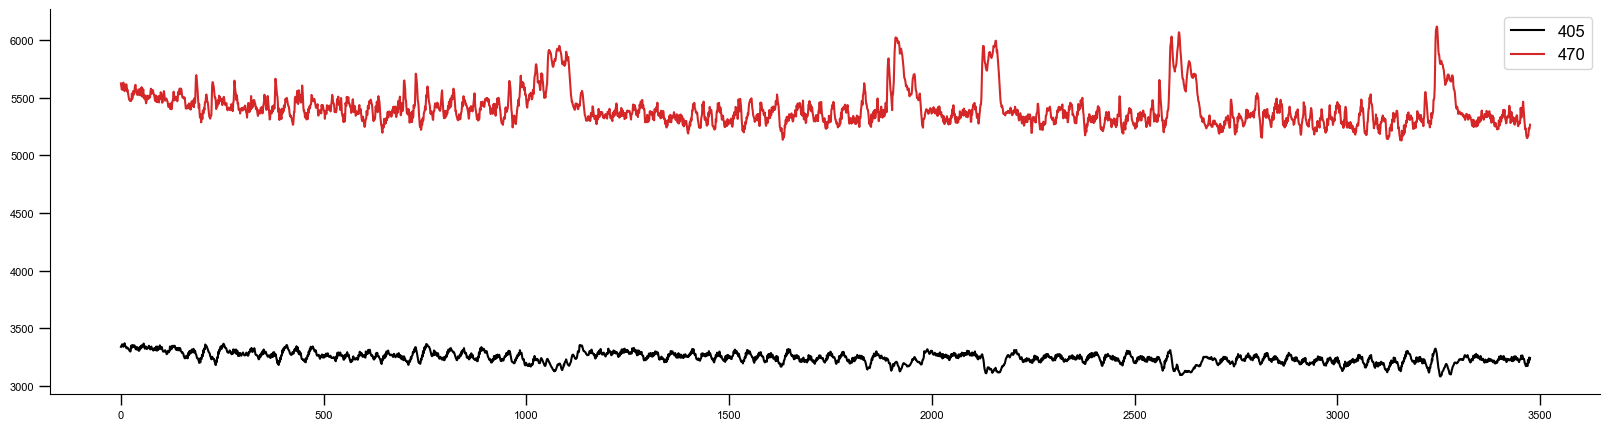

Path: /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/4_SalienceGrating
experiments:
['20240826-145310']


Cropping the images...


Cropping the images...
saving merged tif of 20240826-145310


/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20240826-145310-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


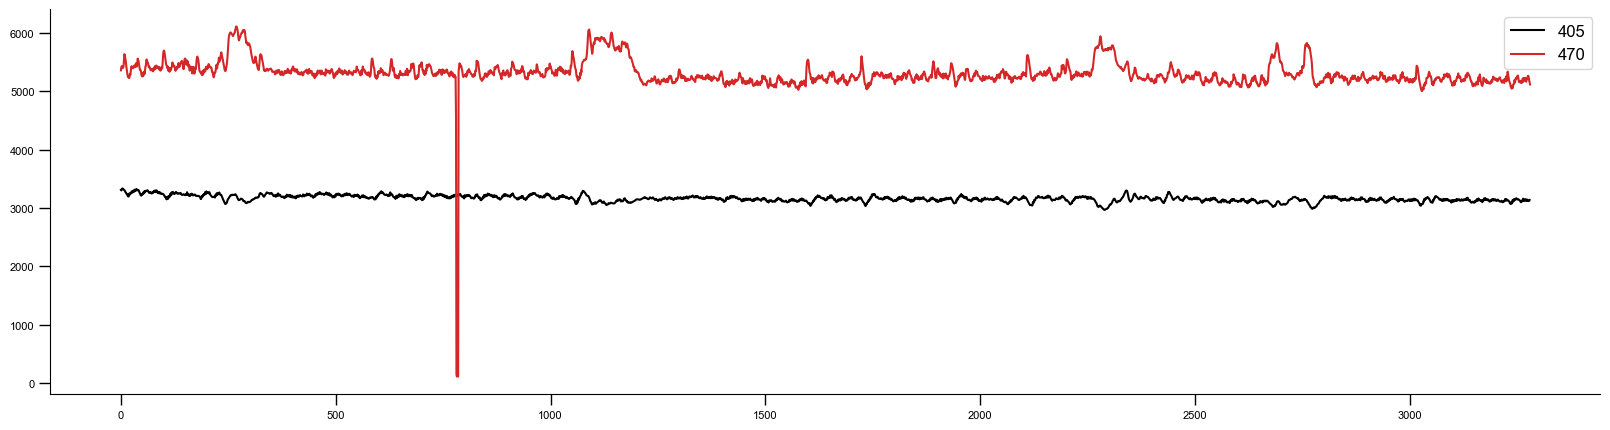

Path: /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/5_SalienceMovingGrating
experiments:
['20240826-145951']


Cropping the images...


Cropping the images...
saving merged tif of 20240826-145951


/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20240826-145951-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


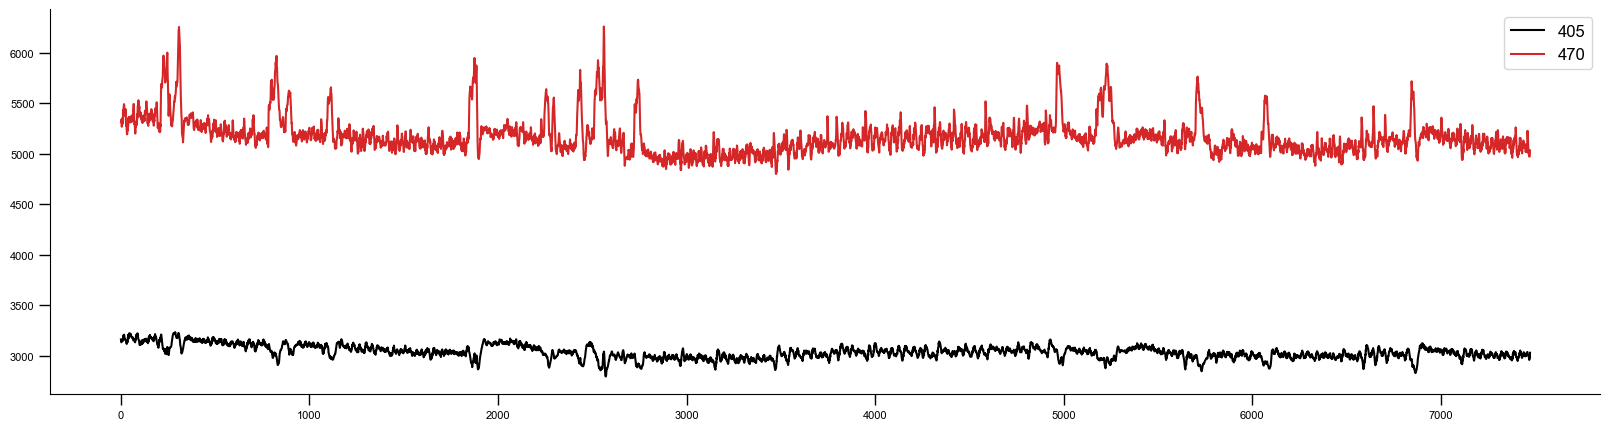

Path: /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/6_Looming
experiments:
['20240826-151247']


Cropping the images...


Cropping the images...
saving merged tif of 20240826-151247


/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20240826-151247-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


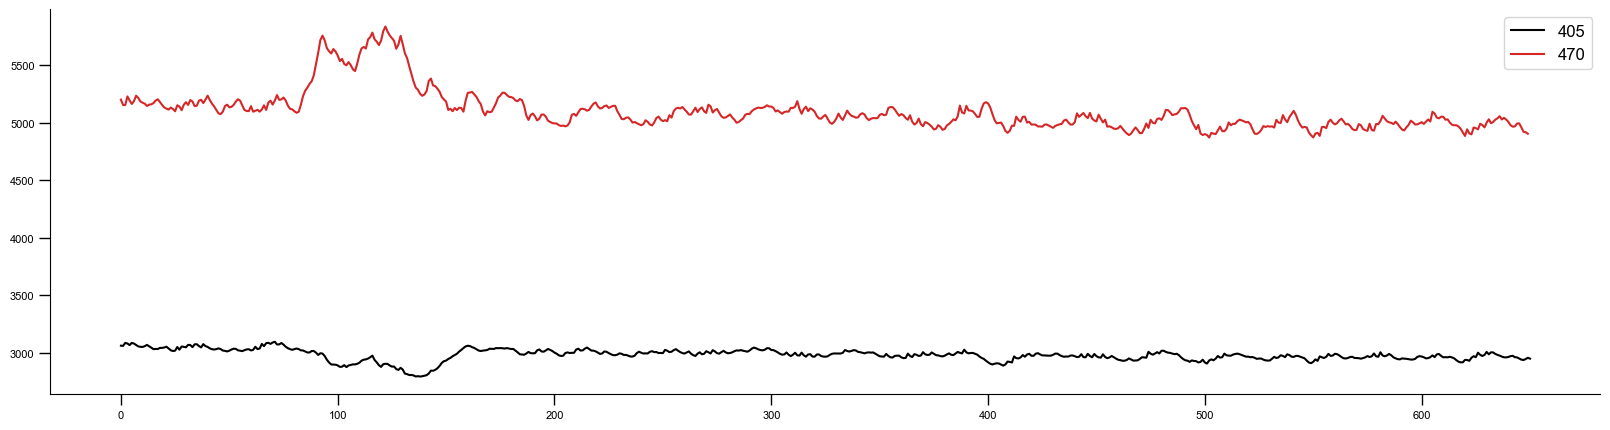

Path: /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/7_NatureMovie
experiments:
['20240826-151440']


Cropping the images...


Cropping the images...
saving merged tif of 20240826-151440


/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20240826-151440-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


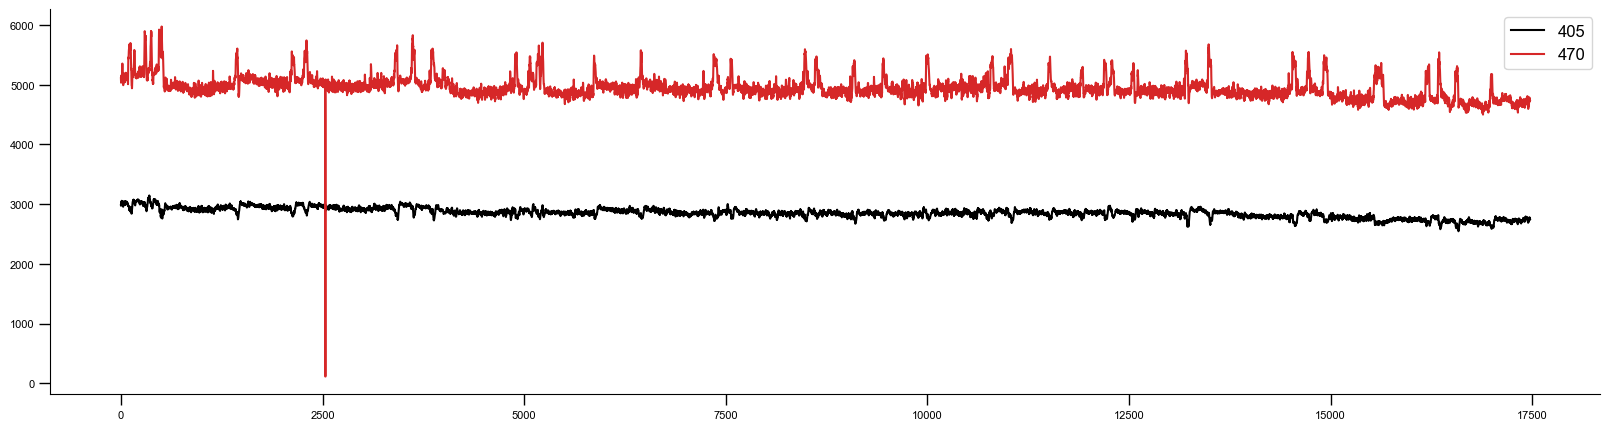

In [14]:
### generate 2-channel tif stack

for path in path_all:
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    # 列出experiments
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiments = list(set([os.path.basename(item)[:15] for item in items]))
    print("experiments:")
    print(experiments)
    
    # 遍历每个experiment，merge channel
    for experiment in experiments:
        os.makedirs(pjoin(processPath, experiment+"-wfield"), exist_ok=True)
        mergePath = pjoin(processPath, experiment+"-wfield")
        merge_file = pjoin(mergePath, experiment+"-merged.tif")
        if not os.path.exists(merge_file):
            tif_405 = organize_tif(pjoin(rawPath, experiment + "-405"))
            tif_405 = rotate_crop_array(tif_405, angle=angle, left=left, top=top, width=width, height=height)
            tif_470 = organize_tif(pjoin(rawPath, experiment + "-470"))
            tif_470 = rotate_crop_array(tif_470, angle=angle, left=left, top=top, width=width, height=height)
            # tif_405_path = pjoin(mergePath, experiment + "-405.tif")
            # tif_470_path = pjoin(mergePath, experiment + "-470.tif")
            # 检查两个通道的深度是否一致
            if tif_405.shape[0] != tif_470.shape[0]:
                n_frames = min(tif_405.shape[0], tif_470.shape[0])
                tif_405 = tif_405[:n_frames]
                tif_470 = tif_470[:n_frames]
            # 将Tiff stack的数据从三维变成四维，不同通道使用第二维区分
            merged_tif = np.concatenate((tif_470[:, np.newaxis], tif_405[:, np.newaxis]), axis=1)
            # 将合并后的图像保存为一个2通道Tiff图像
            print("saving merged tif of "+ experiment)
            imwrite(merge_file, merged_tif, imagej=True, bigtiff=True)
        # imwrite(tif_405_path, tif_405)
        # imwrite(tif_470_path, tif_470)
                        
        # else: print("merged "+experiment+" has existed")
        # plotFluor(path, experiment)
        
    mean_values_405 = pjoin(path, "process", '{}-405-Values.csv'.format(experiment))
    mean_values_470 = pjoin(path, "process", '{}-470-Values.csv'.format(experiment))
    # read data from csv file as numpy array
    mean_values_405 = np.loadtxt(mean_values_405, delimiter=',')
    mean_values_470 = np.loadtxt(mean_values_470, delimiter=',')

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(mean_values_405, label='405')
    ax.plot(mean_values_470, label='470')
    ax.legend()
    plt.show()
    
# print("All merging finished!")

In [ ]:
# images to movie for hehavioral data
path = path_all[1]
rawPath = pjoin(path, "raw")
processPath = pjoin(path, "process")
items = glob(pjoin(rawPath, '202?????-??????-4*'))
experiment = list(set([os.path.basename(item)[:15] for item in items]))
print("experiments:", experiment)
mergePath = pjoin(processPath, experiment[0]+"-wfield")
event_file = pjoin(mergePath, experiment[0]+"-event.tif")
print("event file:", event_file)
if not os.path.exists(event_file):
    tif_event = organize_tif(pjoin(rawPath, experiment[0] + "-event"))
    # imwrite(event_file, tif_event)

Create binary file

In [15]:
path_wfield_all = glob(pjoin(path_0, '*/process/*-wfield'))
print('All the wfield-path:\n'+"\n".join(path_wfield_all))

All the wfield-path:
/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous/process/20240826-140905-wfield
/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy/process/20240826-142921-wfield
/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/3_Movingbar/process/20240826-144645-wfield
/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/4_SalienceGrating/process/20240826-145310-wfield
/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/5_SalienceMovingGrating/process/20240826-145951-wfield
/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/6_Looming/process/20240826-151247-wfield
/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/7_NatureMovie/process/20240826-151440-wfield


In [16]:
path = path_wfield_all[0]
tif_stack = load_stack(path, nchannels=2)
if tif_stack.shape[0] == 0:
    raise ValueError('The shape of the stack may be wrong!')
tif_stack.export_binary(foldername=path, basename='{}'.format(tif_stack.shape[0]))


Exporting binary: 100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


In [11]:
bin_file = glob(pjoin(path, '*.bin'))[0]
print(bin_file)
dat = mmap_dat(bin_file)

/home/wrx/Data_WF/WF_WRX/P42/20240726/saline/1_Retinotopy/process/20240726-154732-wfield/7997_2_512_512_uint16.bin


Check and replace outliers

Path: /home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous
experiments: ['20240826-140905']


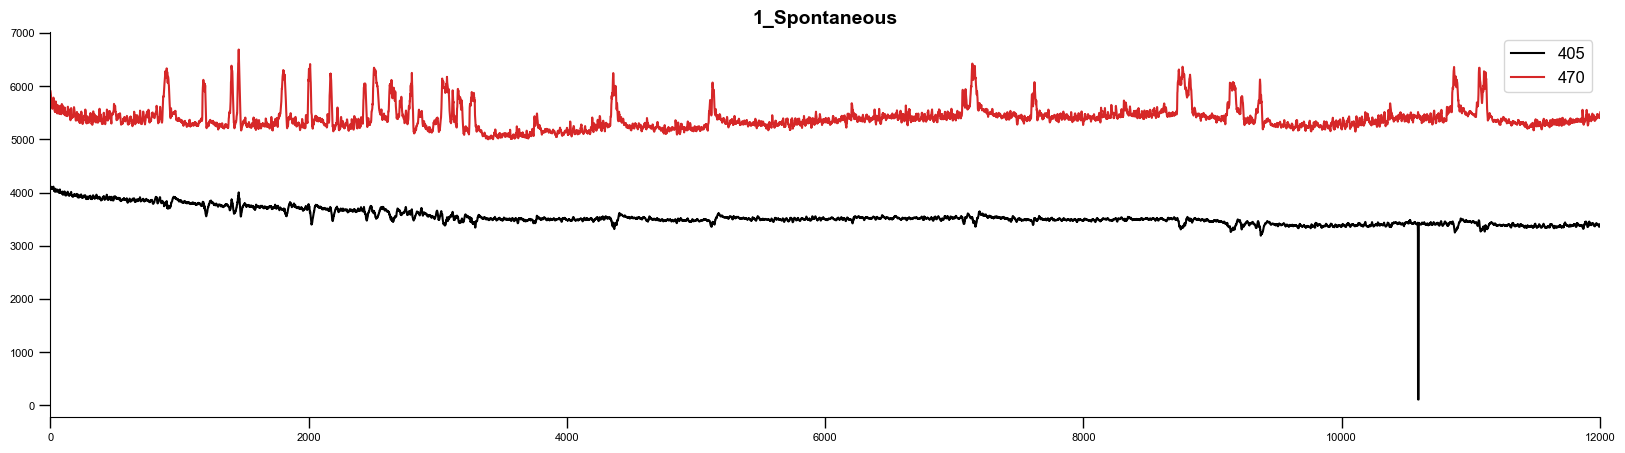

In [17]:
for path in [path_all[0]]:
    stim_name = os.path.split(path)[-1]
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    # 列出experiments
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiments = list(set([os.path.basename(item)[:15] for item in items]))
    print("experiments:", experiments)
    
    # 遍历每个experiment，merge channel
    for experiment in experiments:

        values_405_path = pjoin(path, "process", '{}-405-Values.csv'.format(experiment))
        values_470_path = pjoin(path, "process", '{}-470-Values.csv'.format(experiment))
        # read data from csv file as numpy array
        mean_values_405 = np.loadtxt(values_405_path, delimiter=',')
        mean_values_470 = np.loadtxt(values_470_path, delimiter=',')

        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_values_405, label='405')
        ax.plot(mean_values_470, label='470')
        ax.set_xlim(0, len(mean_values_405))
        # ax.set_xlim(8700, 8900)
        # 1262 1512 4552 4842 5082
        # ax.set_ylim(2000, 4000)
        # print(outlier_index[1])
        # for idx in outlier_index[1]:
        #     ax.axvline(x=idx, color='r', linestyle='--')
        ax.legend()
        plt.title(stim_name)
        plt.show()

In [18]:
def detect_outliers(mean_values, diff_time, lum_thr_coef=0.3, time_thr=10):
    '''
    Detect outliers in the mean_values array.
    There are two types of outliers:
    1. dim: the LED not normaly lighted, the mean value is lower than normal.
    2. cross-channel: the 405 or 470 channel frames wrongly recoreded.
    Parameters:
        mean_values: numpy array, the mean values of the image stack. 
        The first column is the mean values of 470 channel, the second column is the mean values of 405 channel.
        lum_thr_coef: luminance threshold coefficient for detecting dim outliers.
        # diff_thr_coef=0.1, diff_thr_coef: float, the threshold coefficient for detecting cross-channel outliers.
    Returns:
        outlier_index: numpy array, the index of the outliers, 
        each row contains the start and end index of the outliers,
        the value of mean_values[start:end] is considered as outliers.
    '''
    # detecting dim outliers
    outlier_lum_470 = mean_values[:, 0] < np.mean(mean_values[:, 0])*lum_thr_coef
    outlier_lum_idx_470 = np.where(outlier_lum_470)[0]
    if len(outlier_lum_idx_470) > 0:
        outlier_lum_idx_470 = np.append(outlier_lum_idx_470, outlier_lum_idx_470[-1]+1)
    outlier_lum_405 = mean_values[:, 1] < np.mean(mean_values[:, 1])*lum_thr_coef
    outlier_lum_idx_405 = np.where(outlier_lum_405)[0]
    if len(outlier_lum_idx_405) > 0:
        outlier_lum_idx_405 = np.append(outlier_lum_idx_405, outlier_lum_idx_405[-1]+1)

    # # detecting cross-channel outliers based on the difference of the mean values of each channel
    # diff = np.diff(mean_values)
    # # outlier_rise = np.logical_and(diff > np.mean(mean_values)*diff_thr_coef, np.logical_not(outlier_lum[1:]))
    # outlier_rise = diff > np.mean(mean_values)*diff_thr_coef
    # outlier_rise_index = np.where(outlier_rise)[0] + 1
    # outlier_rise_index = np.setdiff1d(outlier_rise_index, outlier_lum_idx) # remove dim outliers

    # # outlier_fall = np.logical_and(diff < -np.mean(mean_values)*diff_thr_coef, np.logical_not(outlier_lum[1:]))
    # outlier_fall = diff < -np.mean(mean_values)*diff_thr_coef
    # outlier_fall_index = np.where(outlier_fall)[0] + 1
    # outlier_fall_index = np.setdiff1d(outlier_fall_index, outlier_lum_idx) # remove dim outliers
    # if len(outlier_lum_idx) == 0 and len(outlier_rise_index) == 0 and len(outlier_fall_index) == 0:
    #     print('No outliers detected!')
    #     return None
    # else:
    #     print('Outliers detected!')
    # if len(outlier_rise_index) == len(outlier_fall_index):
    #     outlier_cross = np.concatenate((np.expand_dims(outlier_rise_index, axis=1), 
    #                                     np.expand_dims(outlier_fall_index, axis=1)), axis=1)
    # else:
    #     print('Note: detected outliers are not in pairs!')
    #     raise ValueError('Detected cross-channel outliers are not in pairs!')

    time_outliers_idx_470 = np.where(diff_time < (50-time_thr))[0]
    time_outliers_idx_405 = np.where(diff_time > (50+time_thr))[0] + 1

    # false_alarm_idx_470 = []
    # for i in range(0, len(time_outliers_idx_470)):
    #     if not mean_values[time_outliers_idx_470[i], 0] == mean_values[time_outliers_idx_470[i], 1]:
    #         false_alarm_idx_470.append(i)
    # time_outliers_idx_470 = np.delete(time_outliers_idx_470, false_alarm_idx_470) # remove false alarm
    
    # false_alarm_idx_405 = []
    # for i in range(0, len(time_outliers_idx_405)):
    #     if not mean_values[time_outliers_idx_405[i], 1] == mean_values[time_outliers_idx_405[i]-1, 0]:
    #         false_alarm_idx_405.append(i)
    # time_outliers_idx_405 = np.delete(time_outliers_idx_405, false_alarm_idx_405) # remove false alarm

    outlier_lum_exist = np.logical_or(len(outlier_lum_idx_470) > 0, len(outlier_lum_idx_405) > 0)
    time_outliers_exist = np.logical_or(len(time_outliers_idx_470) > 0, len(time_outliers_idx_405) > 0)
    if outlier_lum_exist or time_outliers_exist:
        print('Outliers detected!')
    else:
        print('No outliers detected!')

    outlier_index = [time_outliers_idx_470, time_outliers_idx_405]

    return outlier_index

In [19]:
path_all

['/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous',
 '/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/2_Retinotopy',
 '/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/3_Movingbar',
 '/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/4_SalienceGrating',
 '/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/5_SalienceMovingGrating',
 '/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/6_Looming',
 '/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/7_NatureMovie']

In [20]:
path = path_all[0]
print(path)

# mean_values = np.concatenate((mean_values_470[:, np.newaxis], mean_values_405[:, np.newaxis]), axis=1)
time_stamp_405 = np.loadtxt(glob(pjoin(path, "raw", '*-405Timestamp.csv'))[0], delimiter=',')
time_stamp_470 = np.loadtxt(glob(pjoin(path, "raw", '*-470Timestamp.csv'))[0], delimiter=',')

if not len(time_stamp_405) == len(time_stamp_470):
    _len = min(len(time_stamp_405), len(time_stamp_470))
    time_stamp_405 = time_stamp_405[:_len]
    time_stamp_470 = time_stamp_470[:_len]

/home/wrx/Data_WF/WF_WRX/Q38/20240826_saline/1_Spontaneous


In [21]:
def detect_time_outlier(time_stamp_470, time_stamp_405, time_thr=10):
    diff_time = abs(time_stamp_470 - time_stamp_405)
    time_outliers_idx_470 = np.where(diff_time < (50-time_thr))[0]
    time_outliers_idx_405 = np.where(diff_time > (50+time_thr))[0] + 1

    if time_stamp_470[0] > time_stamp_405[0]: # 470 channel starts first
        return time_outliers_idx_470, time_outliers_idx_405
    else: # 405 channel starts first
        return time_outliers_idx_405, time_outliers_idx_470

outlier_index = detect_time_outlier(time_stamp_470, time_stamp_405)
print(outlier_index)

(array([], dtype=int64), array([], dtype=int64))


In [22]:
def correct_outliers(bin_path, outlier_index_470, outlier_index_405):
    '''
    Correct the outliers frames in the merged tiff file.
    Parameters:
        bin_path: string, the path of the bin file.
        outlier_index_405: numpy array, the index of the outliers in 405 channel.
        outlier_index_470: numpy array, the index of the outliers in 470 channel.
    '''

    if (outlier_index_470 is not None) or (outlier_index_405 is not None):
        print('There are outliers frames to be corrected!')
        bin_name = os.path.splitext(os.path.basename(bin_file))[0]
        dtype = bin_name.split('_')[-1]
        shape = tuple([int(i) for i in bin_name.split('_')[:-1]])
        images = np.memmap(bin_path, dtype=dtype, mode='r+', shape=shape)
        if outlier_index_470 is not None:
            for i in range(outlier_index_470.shape[0]):
                start, end = outlier_index_470[i], outlier_index_470[i] +1
                images[start:end, 0, :, :] = (images[start-1, 0, :, :] + images[end, 0, :, :]) / 2
        if outlier_index_405 is not None:
            for i in range(outlier_index_405.shape[0]):
                start, end = outlier_index_405[i], outlier_index_405[i] +1
                images[start:end, 0, :, :] = (images[start-1, 0, :, :] + images[end, 0, :, :]) / 2 # in this case, 470 channel also need to be corrected
                images[start:end, 1, :, :] = (images[start-1, 1, :, :] + images[end, 1, :, :]) / 2
        images.flush()
        print('Outliers frames corrected!')
    else:
        print('No outliers frames to correct!')

    return images


In [ ]:
len(outlier_index[0])

In [ ]:
if outlier_index[0].size == 0 and outlier_index[1].size == 0:
    print('No outliers detected!')
    dat = mmap_dat(bin_file)
else:
    print('Outliers detected!')
    dat = correct_outliers(bin_file, outlier_index_470=outlier_index[0], outlier_index_405=outlier_index[1])

    if plot_test:
    # to check the mean values of every frame of 470 and 405 channel
    mean_470 = np.mean(dat[:, 0, :, :], axis=(1, 2))
    mean_405 = np.mean(dat[:, 1, :, :], axis=(1, 2))
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(mean_405, label='405')
    ax.plot(mean_470, label='470')
    plt.legend()
    plt.show()


In [ ]:
from ipywidgets import interact

def display_wrapper(images, cmap='gray', figsize=(5,5), colorbar=False):
    # max = np.max(images) * 0.85
    # min = np.min(images) + abs(np.min(images) * 0.15)
    def display_images(frame):
    
        plt.figure(figsize=figsize)
        # plt.imshow(images[frame], cmap=cmap, vmax=max, vmin=min)
        plt.imshow(images[frame], cmap=cmap)

        if colorbar:
            plt.colorbar()
        plt.axis('off')
        plt.show()

    frame_slider = interact(display_images, frame=(0, len(images)-1, 1))
    display(frame_slider)

# display_wrapper(images)

Prepressing data

In [ ]:
path_wfield_all

In [ ]:
### 生成trial_onsets.npy

n_movie_rep = 5

for path_wfield in [path_wfield_all[0]]:
    
    experiment = os.path.basename(path_wfield)[:15]
    rawPath = pjoin(path_wfield,'../../raw')
    merge_file = pjoin(path_wfield, experiment+"-merged.tif")
    n_frames = len(TiffFile(merge_file).pages)//2

    if os.path.exists(pjoin(rawPath, experiment + ".csv")):
        # generate trial_onsets.npy
        # trial_onsets.npy is a Nx3 array. The columns are: trial number, onset of the trial (frame index), offset of the trial.
        if not os.path.exists(pjoin(path_wfield, 'trials.csv')):
            stimfile = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
            stim_delay = pd.read_csv(pjoin(rawPath, experiment + "-470Timestamp.csv"), header=None).values
            stim_delay = int(stim_delay[0]/10)
            
            stim = np.zeros(n_frames)
            for i in range(n_frames):
                stim[i] = stimfile[(i * 10 + stim_delay), 0]
            single_0_indices = np.where((np.diff(np.append(stim, 0)) == 1) & (np.diff(stim, prepend=0) == -1))[0]
            single_1_indices = np.where((np.diff(np.append(stim, 0)) == -1) & (np.diff(stim, prepend=0) == 1))[0]
            stim[single_1_indices] = 0
            stim[single_0_indices] = 1
            
            onset = np.where(np.diff(stim) == 1)[0] + 1
            offset = np.where(np.diff(stim) == -1)[0] + 1
            trials_csv = np.stack((np.arange(len(onset)), onset, offset, offset-onset), axis=1)  # 这个用来自己检查一下以及自己后续分析
            np.savetxt(pjoin(path_wfield, "trials.csv"), trials_csv, delimiter=",")
            print("generate trials.csv of "+experiment)
            
            if 'Retinotopy' in path_wfield:
                trial_onsets = np.stack((np.arange(len(onset)), onset - 30, offset), axis=1)  # 这个文件给wfield软件做SVD用
                np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)
            
            elif 'natural-movie' in path_wfield:
                n_movie = len(onset)//n_movie_rep
                trial_onsets = np.empty((n_movie,3))
                for i in range(n_movie):
                    trial_onsets[i] = [i, onset[i*n_movie_rep] - 100, offset[i*n_movie_rep]]
                np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
            # elif 'speed' in path_wfield:
            #     trial_onsets = [0, onset[0] - 100, offset[0]]
            #     np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
        else: print("trials.csv of "+experiment+" has existed")

    else: print(experiment, 'without stim-file, skip')
            
print("\nAll generation of trials-file finished!")


In [ ]:
start_idx = 500
end_idx = 1000
concat_dat = np.concatenate((dat[start_idx:end_idx, 0, :, :], dat[start_idx:end_idx, 1, :, :]), axis=2)

In [ ]:
display_wrapper(concat_dat, cmap='gray', figsize=(15, 7.5))

In [ ]:
# save the concatenated data as tiff file
tif_path = pjoin(path_wfield_all[0], 'concatenated.tif')
print('saving concatenated tif file:', tif_path)
imwrite(tif_path, concat_dat)

In [ ]:
from wfield.ncaas import load_and_motion_correct
dat_motion_corr = load_and_motion_correct(bin_file)

In [ ]:
from wfield.viz import nb_play_movie

In [ ]:
display_wrapper(dat_motion_corr[:,1,:,:])

Computes baseline

In [ ]:
path = path_wfield_all[0]
print(path)

In [ ]:
trial_onsets = np.load(pjoin(path, 'trial_onsets.npy')).astype(int)
nbaseline_frames = 30
frames_average_trials = frames_average_for_trials(dat,
                                           trial_onsets[:,2],
                                           nbaseline_frames)
# Compute the average of all trials and save it
np.save(pjoin(path, 'frames_average.npy'), frames_average_trials.mean(axis=0))

In [ ]:
if 'frames_average_trials' not in locals():
    baseline_frame = np.load(pjoin(path_wfield_all[0],'frames_average.npy'))
else:
    baseline_frame = frames_average_trials.mean(axis=0)

if plot_test:
    plt.imshow(baseline_frame[0], cmap='gray')
    plt.show()


In [ ]:
start_idx = 0
end_idx = 500
delt_470 = (dat[start_idx:end_idx, 0, :, :] - baseline_frame[0]) / baseline_frame[0]
display_wrapper(delt_470, cmap='gray', figsize=(5, 5))

In [ ]:
delt_405 = (dat[start_idx:end_idx, 1, :, :] - baseline_frame[1]) / baseline_frame[1]
display_wrapper(delt_405, cmap='gray', figsize=(5, 5))

In [ ]:
corr_470_405 = delt_470 - delt_405
display_wrapper(corr_470_405, cmap='gray', figsize=(7.5, 7.5))

In [ ]:
def standardization(data):
    stand = data - data.mean() / np.std(data)
    return stand

def normalization(data):
    norm = (data - data.min()) / (data.max() - data.min())
    return norm

In [ ]:
coffers = np.zeros((frames_average_trials.shape[0], frames_average_trials.shape[2], frames_average_trials.shape[3]))
combines = np.zeros((frames_average_trials.shape[0], frames_average_trials.shape[2], frames_average_trials.shape[3]*3))
for i in range(frames_average_trials.shape[0]):
    cof = np.divide(frames_average_trials[i, 0, :, :], frames_average_trials[i, 1, :, :])
    coffers[i] = cof

    standardized_470 = standardization(frames_average_trials[i, 0, :, :])
    standardized_405 = standardization(frames_average_trials[i, 1, :, :])
    standardized_cof = standardization(cof)
    normalized_470 = normalization(frames_average_trials[i, 0, :, :])
    normalized_405 = normalization(frames_average_trials[i, 1, :, :])
    normalized_cof = normalization(cof)
    # combines[i] = np.concatenate((standardized_470, standardized_405, standardized_cof), axis=1)
    combines[i] = np.concatenate((normalized_470, normalized_405, normalized_cof), axis=1)


# cof = np.divide(frames_average_trials[i, 0, :, :], frames_average_trials[i, 1, :, :])
# plt.imshow(cof, cmap='jet')
# plt.colorbar()
# plt.show()


In [ ]:
display_wrapper(coffers, cmap='jet', colorbar=True)

In [ ]:
display_wrapper(frames_average_trials[:, 0, :, :])

In [ ]:
display_wrapper(combines, figsize=(15, 5), cmap='jet')

Approximate single value decomposition

In [ ]:
from wfield import approximate_svd

In [ ]:
frames_average_trials[-1].shape

In [ ]:
frames_average_trials.mean(axis=0).shape

In [ ]:
# U, SVT = approximate_svd(dat, frames_average_trials, onsets=trial_onsets[:,2])
# U, SVT = approximate_svd(dat, frames_average_trials[-1])
U, SVT = approximate_svd(dat, frames_average_trials.mean(axis=0))
np.save(pjoin(path,'U.npy'),U)
np.save(pjoin(path,'SVT.npy'),SVT)

Hemodynamic correction

In [15]:
path = '/home/wrx/Data_WF/WF_WRX/P42/20240726/saline/1_Retinotopy/process/20240726-154732-wfield'
if 'SVT' not in locals():
    SVT = np.load(pjoin(path, 'SVT.npy'))
if 'U' not in locals():
    U = np.load(pjoin(path, 'U.npy'))

In [ ]:
tstart = time.time()

fs = 10
freq_highpass = 0.001
SVT_470 = SVT[:,0::2]
t = np.arange(SVT.shape[1]) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2], SVT[:,1::2], axis=1,
                    fill_value='extrapolate')(t[0::2])
# SVTcorr, rcoeffs, T = hemodynamic_correction(U, 
#                                              SVT_470, 
#                                              SVT_405, 
#                                              fs=fs,
#                                              freq_highpass=freq_highpass,
#                                              freq_lowpass=10)  

print('Done hemodynamic correction in {0} s '.format(time.time()-tstart))
SVTcorr = SVT_470 - SVT_405

# np.save(pjoin(path,'rcoeffs.npy'), rcoeffs)
# np.save(pjoin(path,'T.npy'),T)
np.save(pjoin(path,'SVTcorr.npy'), SVTcorr)

In [18]:
if 'SVTcorr' not in locals():
    SVTcorr = np.load(pjoin(path, 'SVTcorr.npy'))

In [ ]:
# compare the correct method
correct_compare = np.concatenate((corr_470_405, _d), axis=2)
display_wrapper(correct_compare, figsize=(15, 7.5))
# save the correct_compare as tiff file
# tif_path = pjoin(path_wfield_all[0], 'correct_compare.tif')
# print('saving correct_compare tif file:', tif_path)
# imwrite(tif_path, correct_compare.astype(np.float32))

In [ ]:
# for path_wfield in [path_wfield_all[0]]:
#     if len(glob(pjoin(path_wfield, '*-merged.tif'))) == 0:
#         print(path_wfield,"can't find merged tiff file！\n")
#     elif len(glob(pjoin(path_wfield, '*-merged.tif'))) > 1:
#         print(path_wfield,"exist multiple merged tiff file！\n")
#     elif os.path.exists(pjoin(path_wfield, 'SVTcorr.npy')):
#         print(path_wfield,'analysis has been finished！\n')
#     else:
#         print('Start analyze',path_wfield)
#         if 'natural-movie' or 'speed' in path_wfield:
#             nbaseline_frames = 100
#         else:
#             nbaseline_frames = 30
#         command = "wfield preprocess --nchannels 2 --nbaseline-frames {} --functional-channel 0 --fs 10 -o {} {}".format(nbaseline_frames,path_wfield,path_wfield)
#         logfile = pjoin(path_wfield, 'log.txt')
#         with open(logfile, "w") as log:
#             result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
#             log.write(result.stdout)
#         if result.returncode == 0:
#             print('Finish analyzing',path_wfield,'\n')
#         else:
#             print('！！！Error occured when analyzing',path_wfield,'\n')
        
# print('\nMotion correction, single value decomposition, hemodynamic correction. All finished!')

PhaseMap

In [ ]:
# using phasemap.ipynb

Plot HVA

In [ ]:
# using plot_HVA.ipynb
# using match_dorsal_cortex_to_allen.ipynb to match the dorsal cortex to allen atlas

Extract Trace

In [1]:
import NeuroAnalysisTools.core.FileTools as ft

ModuleNotFoundError: No module named 'NeuroAnalysisTools.core'

In [2]:
# pjoin(path_wfield_all[0],'retinotopy_out.pkl')
path = '/home/wrx/Data_WF/WF_WRX/P42/20240726/saline/1_Retinotopy/process/20240726-154732-retinotopy/retinotopy_out.pkl'
pkl_dict = ft.loadFile(path)
print(pkl_dict.keys())
print(pkl_dict['finalPatchesMarked'].keys())
type(pkl_dict['finalPatchesMarked']['V1'])
pkl_dict['finalPatchesMarked']['V1'].array
pkl_dict['finalPatchesMarked']['V1'].getMask()

dict_keys(['mouseID', 'dateRecorded', 'altPosMap', 'aziPosMap', 'altPowerMap', 'aziPowerMap', 'vasculatureMap', 'comments', 'params', 'altPosMapf', 'aziPosMapf', 'altPowerMapf', 'aziPowerMapf', 'signMap', 'signMapf', 'rawPatchMap', 'eccentricityMapf', 'finalPatches', 'finalPatchesMarked'])
dict_keys(['patch08', 'V1', 'LM', 'AM', 'PM', 'RL', 'AL', 'A'])


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [26]:
U.shape[:2]

(512, 512)

In [29]:
from wfield_utils import reconstruct
mov = reconstruct(U,SVTcorr).reshape(SVTcorr.shape[1], *U.shape[:2])
print(mov.shape)

(7997, 512, 512)


In [30]:
trace = pkl_dict['finalPatchesMarked']['V1'].getTrace(mov=mov)
print(trace.shape)

(7997,)


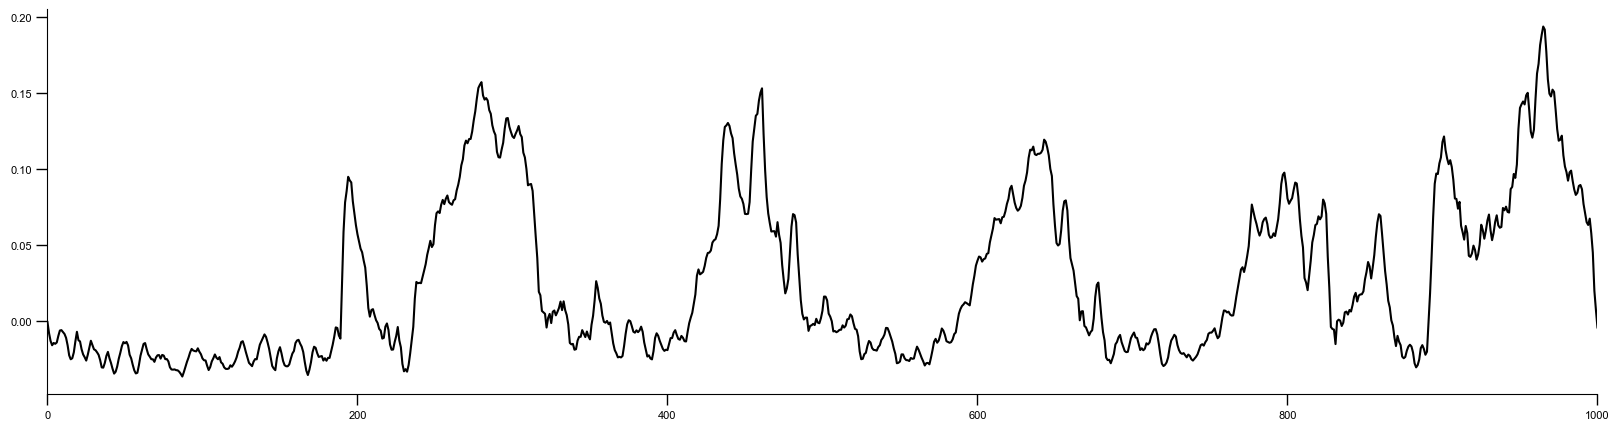

In [33]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(trace)
# ax.set_xlim(0, 1000)
plt.show()